In [1]:
%cd ..

/home/jairo/Documentos/GitHub/parallel-kink-scattering


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from modules.numeric import *
from modules.numeric.boundaries import *
from modules.numeric.models import *
from modules.tools import *

# Global definitions

In [26]:
phi4 = Phi4()

L = 40
N = 1000
DX = 2*L/(N - 1)
DT = 0.7*DX
LAMB = 1
X0 = 10

def y0(x, v):
    return np.stack((
        phi4.kink(x + 20, 0, v) - phi4.kink(x + 10, 0, 0) - 1,
        phi4.kink_dt(x + 20, 0, v) - phi4.kink_dt(x + 10, 0, 0)
    ))

booster = Booster(
    x_lattice= (-L, L, N), 
    dt= DT, 
    order= 6,
    y0= y0,
    pot_diff= phi4.diff,
    boundaries= ('reflective', 'reflective')
)

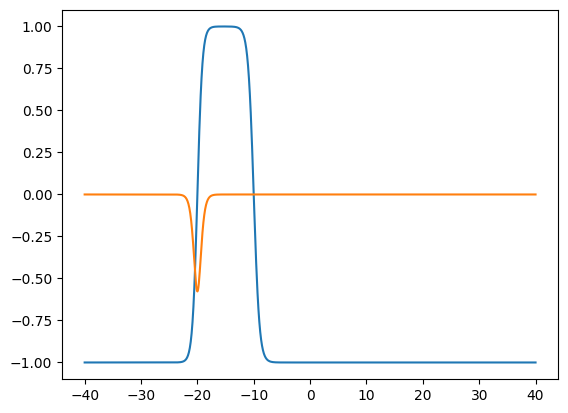

In [27]:
for u in y0(booster.x, 0.5):
    plt.plot(booster.x, u)

In [28]:
def wall(k, H):
    def wrapped(t, Y):
        Y[-1][0][k] = H
        return Y
    return wrapped

(0.0, 120.0)

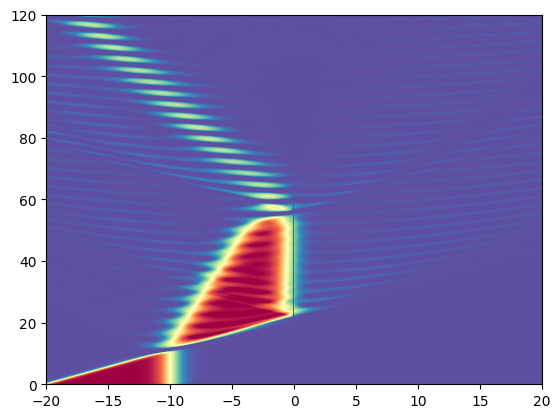

In [36]:
v = 0.9
k = argnearest(booster.x, 0)
lat, y, dydt = booster.run(X0/v + 300, y0_params={'v':v}, callback=wall(k, y0(booster.x[k], 0)[0]))
plt.imshow(y, cmap='Spectral_r', vmin=-1, vmax=1, extent=(lat.x.min(), lat.x.max(), lat.t.min(), lat.t.max()), aspect='auto', origin='lower')
plt.xlim(-20, 20)
plt.ylim(0, 120)

In [7]:
from celluloid import Camera
from IPython.display import HTML

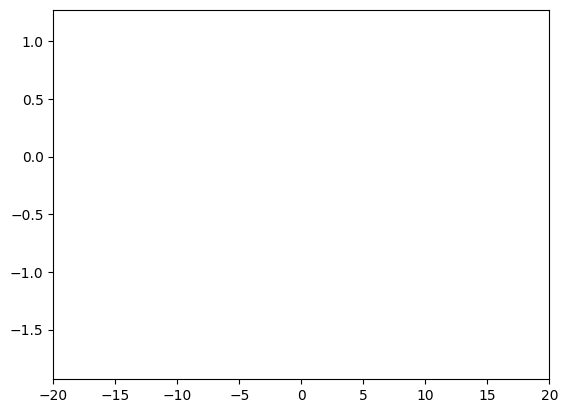

In [33]:
fig = plt.figure()
camera = Camera(fig)
plt.xlim(-20, 20)
for yi in y[:lat.at(t=200)[-1]:5]:
    plt.plot(booster.x, yi, 'k-')
    camera.snap()
anim = camera.animate(interval=10)
HTML(anim.to_html5_video())

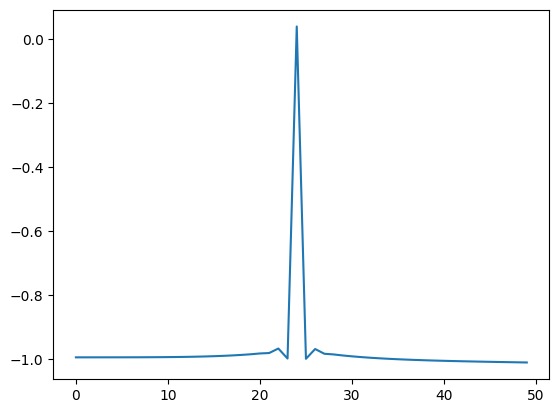

In [53]:
plt.plot(y[1000][475:525])

In [55]:
v = 0.25978
lat, y, _ = COLLIDER.collide((v, -v), LAMB, X0/v + 300)

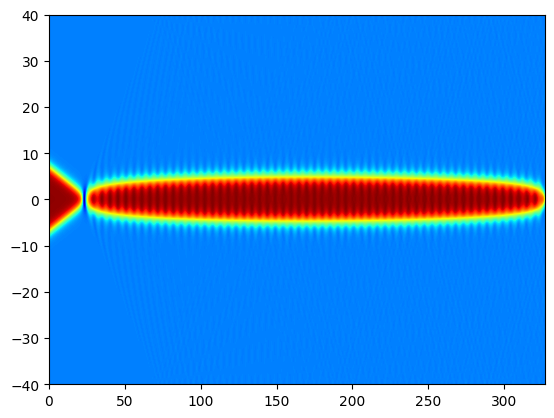

In [56]:
plt.imshow(y.T, cmap='jet', aspect='auto', extent=(lat.t.min(), lat.t.max(), lat.x.min(), lat.x.max()))
plt.show()

In [6]:
CM = argnearest(COLLIDER.x, 0)

def step_bisec(f, x1, x2, epsilon=1e-3):
    assert x1 < x2
    y1, y2 = f(x1), f(x2)
    assert y1 != y2
    while np.abs(x2-x1) > epsilon:
        xc = (x1 + x2)/2
        yc = f(xc)
        yield xc
        if y1 != yc: x2, y2 = xc, yc
        else: x1, y1 = xc, yc

def get_bounces(v, nmax=None):
    counter = BouncesCounter(CM)
    kw = {'stop_condition': counter.blocker(nmax)} if nmax != None else {}
    COLLIDER.collide((v, -v), LAMB, X0/v + 300, callback=counter, **kw)
    return counter.bounces

def F(n):
    def checkout(v):
        return int(get_bounces(v, nmax=n + 1) == n)
    return checkout

def progress(iterable, size=None):
    if size == None: size = len(iterable)
    for i, value in enumerate(iterable):
        print(f'\r{(i/size*100):.2f} %', end='')
        yield value
    print('\r')

def get_initial_ranges(a, b, Nk, n, rmax=None):
    v_in = a + (b - a)*np.log10(np.linspace(1, 10, Nk))
    initial_range = []
    bounces_counter = partial(get_bounces, nmax=n + 1)
    bounces = np.fromiter(map(bounces_counter, v_in), np.float64)
    for slc in np.ma.clump_masked(np.ma.masked_equal(bounces, n)):
        v_slc = v_in[slc]
        if v_slc.ptp() > 0:
            initial_range.append((v_slc.min(), v_slc.max()))
        if rmax != None and len(initial_range) >= rmax:
            break
    return initial_range

def grind(initial_ranges, n=2, epsilon=1e-7):
    sim_amount = []
    ranges = []
    for vmin, vmax in initial_ranges:
        res = []
        sims = 0
        dv = (vmax - vmin)/2
        for v in (vmin, vmax):
            v1, v2 = v - dv, v + dv
            try:
                steps = tuple(step_bisec(F(n), v1, v2, epsilon=epsilon))
            except Exception as error: 
                print(error)
                sims += 0
                res.append(np.nan)
            else:
                sims += len(steps)
                res.append(steps[-1])
        ranges.append(res)
        sim_amount.append(sims)

    return ranges, sim_amount

# One-bounce

In [7]:
*_, v_c = step_bisec(F(1), 0.1, 0.3, epsilon=1e-7)
v_c

0.25978021621704106

# Two-bounce

In [8]:
%%time
initial_two_range = get_initial_ranges(0.18, v_c, Nk=150, n=2, rmax=5)
initial_two_range

CPU times: user 1min 8s, sys: 4.33 s, total: 1min 13s
Wall time: 1min 13s


[(0.19365885211832276, 0.20342996175683256),
 (0.22435608663978873, 0.22872315910793745),
 (0.23731021319895457, 0.23963241933161786),
 (0.24418616269069546, 0.2451571643858035),
 (0.24821034174859896, 0.24878997045016377)]

In [9]:
%%time
two_bounces, sim_amount = grind(initial_two_range, n=2)
two_bounces

CPU times: user 1min 58s, sys: 8.54 s, total: 2min 7s
Wall time: 2min 7s


[[0.1925532359146428, 0.203442560309757],
 [0.22403296752360755, 0.22886009657623038],
 [0.23712489309895105, 0.23964737250221088],
 [0.24396551820150558, 0.2454613728636471],
 [0.24803111817669177, 0.2489977792265915]]

In [10]:
m = np.arange(5).astype(int) + 1
M = m + 2
df = pd.DataFrame({
    'm': m,
    'v1': [v1 for v1, _ in two_bounces],
    'v2': [v2 for _, v2 in two_bounces]
})

df['dv'] = df.v2-df.v1
df['dv1'] = df.dv/df.dv[0]
df['beta'] = -np.log(df.dv1)/np.log(M/M[m == 1])

df

,m,v1,v2,dv,dv1,beta
0,1,0.192553,0.203443,0.010889,1.000000,NaN
1,2,0.224033,0.228860,0.004827,0.443290,2.827882
2,3,0.237125,0.239647,0.002522,0.231647,2.863092
3,4,0.243966,0.245461,0.001496,0.137369,2.863873
4,5,0.248031,0.248998,0.000967,0.088771,2.858133


In [11]:
print(df.to_latex(index=False))

\begin{tabular}{rrrrrr}
\toprule
m & v1 & v2 & dv & dv1 & beta \\
\midrule
1 & 0.192553 & 0.203443 & 0.010889 & 1.000000 & NaN \\
2 & 0.224033 & 0.228860 & 0.004827 & 0.443290 & 2.827882 \\
3 & 0.237125 & 0.239647 & 0.002522 & 0.231647 & 2.863092 \\
4 & 0.243966 & 0.245461 & 0.001496 & 0.137369 & 2.863873 \\
5 & 0.248031 & 0.248998 & 0.000967 & 0.088771 & 2.858133 \\
\bottomrule
\end{tabular}



In [12]:
sim_amount, sum(sim_amount) + 2*len(sim_amount)

([34, 32, 30, 28, 26], 160)

# Three-bounce

## Mapping the region near first two-bounce window

In [13]:
dv = (two_bounces[1][0] - two_bounces[0][1])/6
VMIN, VMAX = two_bounces[0][1] - dv, two_bounces[1][0] + dv
v_in = np.linspace(VMIN, VMAX, 200)
Ycm = []
for v in progress(v_in):
    counter = BouncesCounter(CM)
    ycm = []
    _, y, _ = COLLIDER.collide((v, -v), LAMB, 300, callback=composite(counter, catch_cm(CM, ycm), memory_economize))
    Ycm.append(ycm)

0.00 %

99.50 %


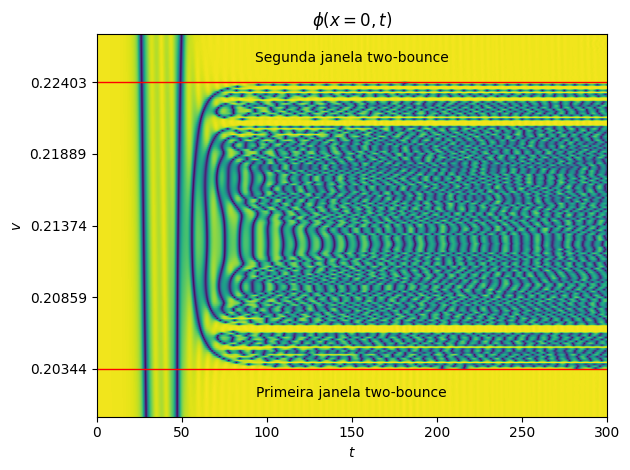

In [14]:
plt.imshow(Ycm, aspect='auto', extent=(0, 300, VMIN, VMAX), origin='lower')

Vs = (two_bounces[0][1], two_bounces[1][0])
for v in Vs:
    plt.axhline(v, c='r', lw=1)
yticks = np.linspace(*Vs, 5)
plt.yticks(yticks)

plt.xlabel(r'$t$')
plt.ylabel(r'$v$')

plt.title(r'$\phi(x=0, t)$')
plt.text(150, (VMIN + Vs[0])/2, r'Primeira janela two-bounce', horizontalalignment='center', verticalalignment='center')
plt.text(150, (VMAX + Vs[1])/2, r'Segunda janela two-bounce', horizontalalignment='center', verticalalignment='center')
plt.tight_layout()
plt.savefig('reports/anninos/three_mapping_1.png', pad_inches=0)
plt.show()

In [15]:
%%time
initial_three_range_1 = get_initial_ranges(*yticks[:2][::-1], Nk=250, n=3, rmax=5)
initial_three_range_1

CPU times: user 1min 33s, sys: 4.69 s, total: 1min 38s
Wall time: 1min 38s


[(0.20619787968547754, 0.20652562275583794),
 (0.20486137019767192, 0.20500294275884567),
 (0.20431028998874443, 0.2043706602203778),
 (0.20402022450770568, 0.20405183567936533),
 (0.20385878957720632, 0.20387834283647746)]

In [16]:
%%time
three_bounces_1, sim_amount = grind(initial_three_range_1, n=3, epsilon=1e-8)
three_bounces_1

CPU times: user 1min 48s, sys: 7.64 s, total: 1min 56s
Wall time: 1min 56s


[[0.2061751503114726, 0.20653289915609696],
 [0.20484772621121605, 0.20501857415308172],
 [0.2043030900722032, 0.20437949614661421],
 [0.20401992352242865, 0.20406068773353864],
 [0.20385637406226706, 0.2038820949999997]]

In [17]:
m = np.arange(len(three_bounces_1)).astype(int) + 1
M = m + 1
df = pd.DataFrame({
    'm': m,
    'v1': [v1 for v1, _ in three_bounces_1],
    'v2': [v2 for _, v2 in three_bounces_1]
})

df['dv'] = df.v2-df.v1
df['dvn'] = df.dv/df.dv[1]
df['beta'] = -np.log(df.dvn)/np.log(M/M[m == 2])

df.style.format('{:.7f}')

,m,v1,v2,dv,dvn,beta
0,1.0000000,0.2061752,0.2065329,0.0003577,2.0939605,1.8227395
1,2.0000000,0.2048477,0.2050186,0.0001708,1.0000000,nan
2,3.0000000,0.2043031,0.2043795,0.0000764,0.4472168,2.7972259
3,4.0000000,0.2040199,0.2040607,0.0000408,0.2385994,2.8052027
4,5.0000000,0.2038564,0.2038821,0.0000257,0.1505487,2.7316977


In [18]:
print(df.to_latex(index=False, float_format='%.7f'))

\begin{tabular}{rrrrrr}
\toprule
m & v1 & v2 & dv & dvn & beta \\
\midrule
1 & 0.2061752 & 0.2065329 & 0.0003577 & 2.0939605 & 1.8227395 \\
2 & 0.2048477 & 0.2050186 & 0.0001708 & 1.0000000 & NaN \\
3 & 0.2043031 & 0.2043795 & 0.0000764 & 0.4472168 & 2.7972259 \\
4 & 0.2040199 & 0.2040607 & 0.0000408 & 0.2385994 & 2.8052027 \\
5 & 0.2038564 & 0.2038821 & 0.0000257 & 0.1505487 & 2.7316977 \\
\bottomrule
\end{tabular}



In [19]:
sim_amount

[32, 28, 26, 24, 22]

## Mapping the region outside second two-bounce window

In [20]:
dv = (two_bounces[2][0] - two_bounces[1][1])/6
VMIN, VMAX = two_bounces[1][1] - dv, two_bounces[2][0] + dv
v_in = np.linspace(VMIN, VMAX, 200)
Ycm = []
for v in progress(v_in):
    counter = BouncesCounter(CM)
    ycm = []
    _, y, _ = COLLIDER.collide((v, -v), LAMB, 300, callback=composite(counter, catch_cm(CM, ycm), memory_economize))
    Ycm.append(ycm)

0.00 %

99.50 %


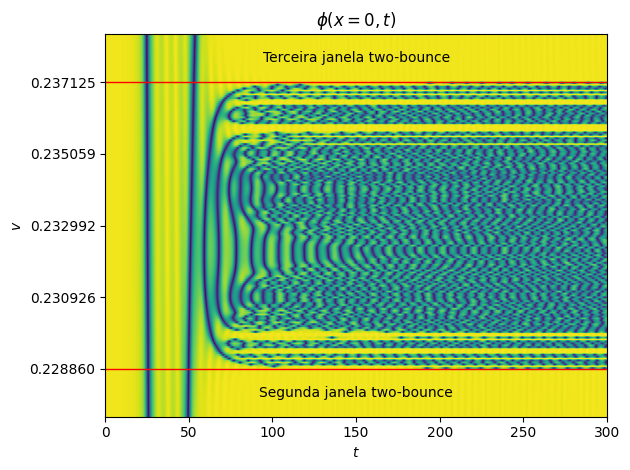

In [21]:
plt.imshow(Ycm, aspect='auto', extent=(0, 300, VMIN, VMAX), origin='lower')

Vs = (two_bounces[1][1], two_bounces[2][0])
for v in Vs:
    plt.axhline(v, c='r', lw=1)
yticks = np.linspace(*Vs, 5)
plt.yticks(yticks)

plt.xlabel(r'$t$')
plt.ylabel(r'$v$')

plt.title(r'$\phi(x=0, t)$')
plt.text(150, (VMIN + Vs[0])/2, r'Segunda janela two-bounce', horizontalalignment='center', verticalalignment='center')
plt.text(150, (VMAX + Vs[1])/2, r'Terceira janela two-bounce', horizontalalignment='center', verticalalignment='center')
plt.tight_layout()
plt.savefig('reports/anninos/three_mapping_2.png', pad_inches=0)
plt.show()

In [22]:
%%time
initial_three_range_2 = get_initial_ranges(*yticks[:2][::-1], Nk=500, n=3, rmax=5)
initial_three_range_2

CPU times: user 3min 12s, sys: 9.73 s, total: 3min 22s
Wall time: 3min 22s


[(0.22975534496103386, 0.22989261433215916),
 (0.22930568430706208, 0.2293661813766335),
 (0.22912776613114325, 0.2291565760275242),
 (0.22904054590955575, 0.22905450651945244),
 (0.22899051453966032, 0.22899803243323005)]

In [23]:
%%time
three_bounces_2, sim_amount = grind(initial_three_range_2, n=3, epsilon=1e-9)
three_bounces_2

CPU times: user 1min 59s, sys: 7.98 s, total: 2min 7s
Wall time: 2min 7s


[[0.22975505643479066, 0.22989371031297035],
 [0.22930327590779281, 0.22936819468395675],
 [0.22912767029744252, 0.2291584425866678],
 [0.22903934190920278, 0.2290562166600813],
 [0.22898892047458091, 0.22899924656569987]]

In [24]:
m = np.arange(len(three_bounces_2)).astype(int) + 1
M = m + 1
df = pd.DataFrame({
    'm': m,
    'v1': [v1 for v1, _ in three_bounces_2],
    'v2': [v2 for _, v2 in three_bounces_2]
})

df['dv'] = df.v2-df.v1
df['dvn'] = df.dv/df.dv[1]
df['beta'] = -np.log(df.dvn)/np.log(M/M[m == 2])

df.style.format('{:.7f}')

,m,v1,v2,dv,dvn,beta
0,1.0000000,0.2297551,0.2298937,0.0001387,2.1358055,1.8715392
1,2.0000000,0.2293033,0.2293682,0.0000649,1.0000000,nan
2,3.0000000,0.2291277,0.2291584,0.0000308,0.4740122,2.5949560
3,4.0000000,0.2290393,0.2290562,0.0000169,0.2599364,2.6375310
4,5.0000000,0.2289889,0.2289992,0.0000103,0.1590617,2.6523416


In [25]:
print(df.to_latex(index=False, float_format='%.7f'))

\begin{tabular}{rrrrrr}
\toprule
m & v1 & v2 & dv & dvn & beta \\
\midrule
1 & 0.2297551 & 0.2298937 & 0.0001387 & 2.1358055 & 1.8715392 \\
2 & 0.2293033 & 0.2293682 & 0.0000649 & 1.0000000 & NaN \\
3 & 0.2291277 & 0.2291584 & 0.0000308 & 0.4740122 & 2.5949560 \\
4 & 0.2290393 & 0.2290562 & 0.0000169 & 0.2599364 & 2.6375310 \\
5 & 0.2289889 & 0.2289992 & 0.0000103 & 0.1590617 & 2.6523416 \\
\bottomrule
\end{tabular}



In [26]:
sim_amount

[36, 32, 30, 28, 26]

# Anninos plots

In [27]:
def plot_cm(v, t_lim=None, **kwargs):
    fig = plt.figure(figsize=(6, 4))
    lat, y, _ = COLLIDER.collide((v, -v), LAMB, X0/v + 300 if t_lim == None else t_lim)
    plt.plot(lat.t, y[:, CM], **kwargs)
    plt.xlim(0, t_lim)
    plt.ylim(-2, 1.5)
    plt.xlabel(r'$t$', fontsize=14)
    plt.ylabel(r'$\phi(x=0,t)$', fontsize=14)
    plt.title(r'$v=%s$'%v)
    fig.savefig(f'reports/anninos/y_cm - v={v}.png', format='png', pad_inches=0)

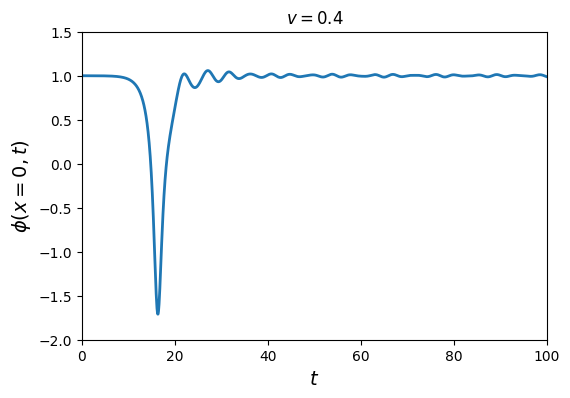

In [28]:
plot_cm(0.4, 100, c='tab:blue', lw=2)
plt.show()

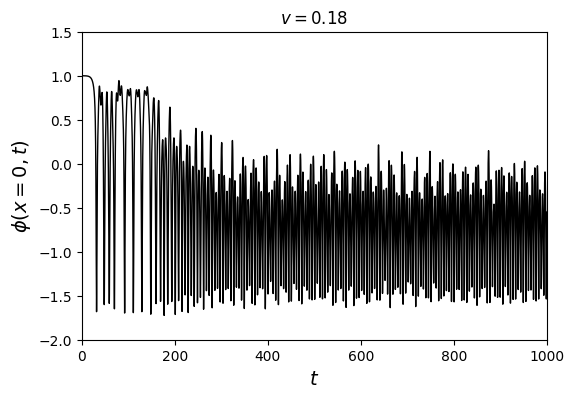

In [29]:
plot_cm(0.18, t_lim=1000, c='k', lw=1)
plt.show()

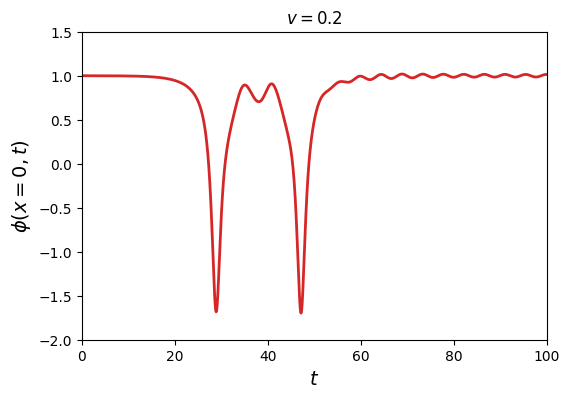

In [30]:
plot_cm(0.2, 100, c='tab:red', lw=2)
plt.show()

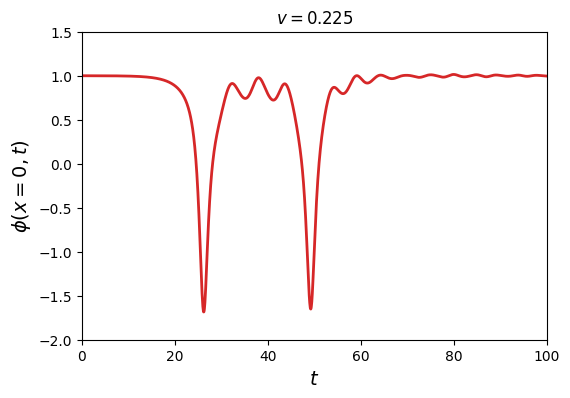

In [31]:
v = 0.225
plot_cm(0.225, 100, c='tab:red', lw=2)
plt.show()

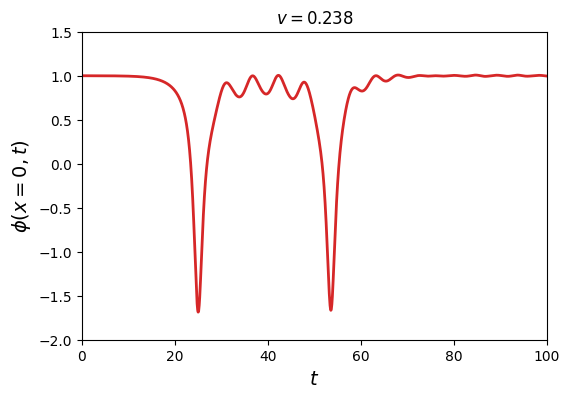

In [32]:
plot_cm(0.238, 100, c='tab:red', lw=2)
plt.show()

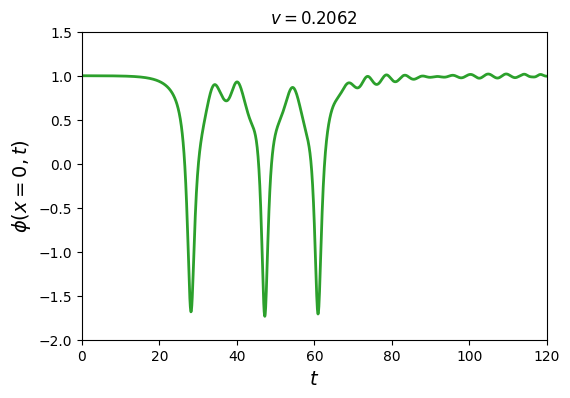

In [33]:
plot_cm(0.2062, 120, c='tab:green', lw=2)
plt.show()

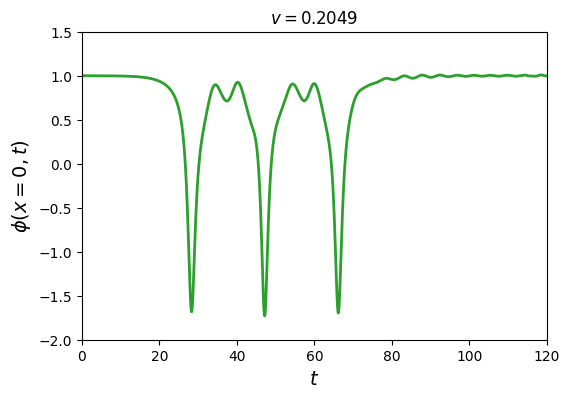

In [34]:
plot_cm(0.2049, 120, c='tab:green', lw=2)
plt.show()

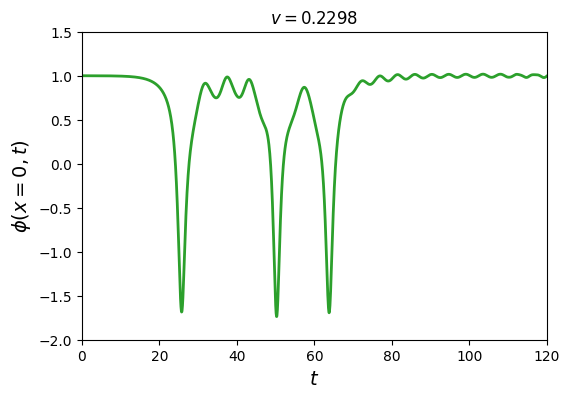

In [35]:
plot_cm(0.2298, 120, c='tab:green', lw=2)
plt.show()

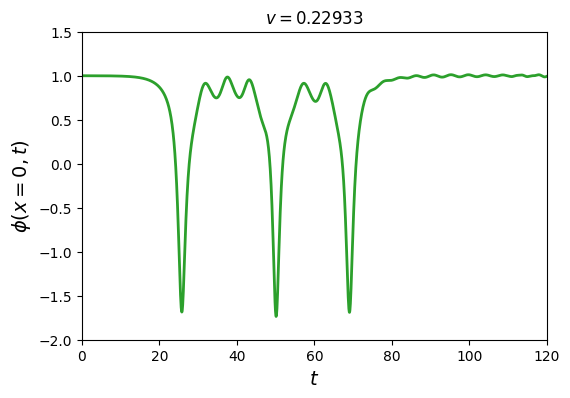

In [36]:
plot_cm(0.22933, 120, c='tab:green', lw=2)
plt.show()

# Resonance

In [13]:
def get_bounces_distance(vs, j=1, k=2, nmax=3):
    T = []
    for v in vs:
        counter = BouncesCounter(CM)
        COLLIDER.collide((v, -v), LAMB, X0/v + 300, callback=counter, stop_condition=counter.blocker(nmax))
        T.append((counter.locs[k-1] - counter.locs[j-1])*DT)
    return T

def linear(x, a, b):
    return a*x + b

def sig_digits(value, error):
    sig = 0
    l, r = str(error).split('.')
    if l == '0':
        for digit in r:
            sig += 1
            if digit != '0': break
    value = np.round(value, sig)
    error = np.round(error, sig)
    return (int(value), int(error)) if str(error).split('.')[-1] == '0' else (value, error)

In [10]:
%%time
initial_two_range = get_initial_ranges(0.18, v_c, Nk=1000, n=2, rmax=15)
initial_two_range

CPU times: user 7min 8s, sys: 26.5 s, total: 7min 34s
Wall time: 7min 35s


[(0.19266885930330846, 0.20338625519263703),
 (0.22406837411782202, 0.22880418096041216),
 (0.23717089064377264, 0.23960130326955725),
 (0.24400365295881027, 0.24544954179114475),
 (0.24804083700730634, 0.24899134345737972),
 (0.2506960332734336, 0.2512993237499523),
 (0.2524752773783755, 0.25293470653193023),
 (0.25379860654396735, 0.2540941145840199),
 (0.25478600730253975, 0.2550016601211384),
 (0.25553499195985324, 0.25571096038109636),
 (0.2561296737265612, 0.256268127887494),
 (0.256611861933542, 0.2567143206804618),
 (0.25701989146947923, 0.25708743166175907),
 (0.25732279089153626, 0.2573897437774291),
 (0.25762306524948886, 0.25765626899680055)]

In [11]:
%%time
two_bounces, sim_amount = grind(initial_two_range, n=2)
two_bounces



CPU times: user 4min 31s, sys: 18.3 s, total: 4min 50s
Wall time: 4min 50s


[[0.19255315865646244, 0.20344259282209065],
 [0.22403303766845026, 0.228860040010237],
 [0.23712497922362613, 0.23964736303031814],
 [0.24396561718691476, 0.24546127904790138],
 [0.24803114861758696, 0.2489977830457561],
 [0.25065825397479413, 0.25132134326319433],
 [0.2524649020862115, 0.25294093170722864],
 [0.25377097481072997, 0.25412564217520717],
 [0.2547526800969312, 0.25502519449855876],
 [0.2555120507643104, 0.2557265122777004],
 [0.2561118937244492, 0.2562840149616244],
 [0.25659430186510024, 0.2567342821257846],
 [0.25698856179044316, 0.25710398692373393],
 [0.2573157948380299, 0.25741217037885616],
 [nan, nan]]

In [12]:
sim_amount

[34, 32, 30, 28, 28, 26, 26, 24, 24, 22, 22, 22, 20, 20, 0]

In [17]:
T2 = get_bounces_distance((v1 for v1, _ in two_bounces[:-1]))
T2

[17.209209209209206,
 22.422422422422418,
 27.747747747747745,
 33.07307307307307,
 38.342342342342334,
 43.61161161161161,
 48.824824824824816,
 54.03803803803803,
 59.25125125125124,
 64.46446446446446,
 69.67767767767766,
 74.89089089089089,
 80.04804804804803,
 85.3173173173173]

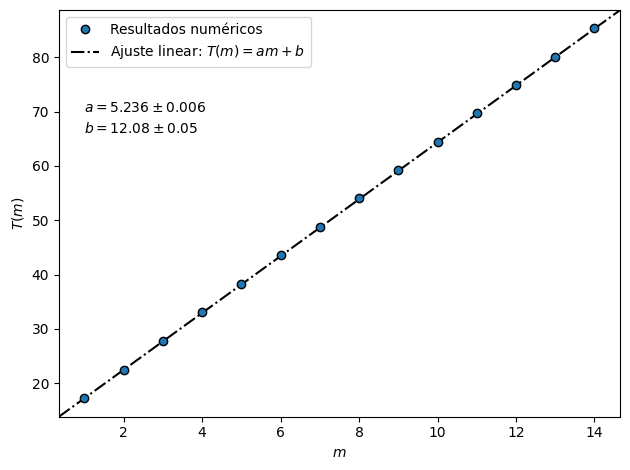

(5.236374836384076, 5.130199320647456, 2.069617749729461)

In [57]:
m = np.arange(len(T2)) + 1
plt.plot(m, T2, 'o', c='tab:blue', markeredgecolor='k', label='Resultados numéricos')

(a, b), pcov = curve_fit(linear, m, T2)
da, db = np.sqrt(np.diag(pcov))
plt.axline((m[0], T2[0]), slope=a, ls='-.', c='k', zorder=0, label=r'Ajuste linear: $T(m) = am + b$')
plt.text(1, 70, r'$a = %s \pm %s$'%sig_digits(a, da))
plt.text(1, 66, r'$b = %s \pm %s$'%sig_digits(b, db))

plt.legend()
plt.xlabel(r'$m$')
plt.ylabel(r'$T(m)$')

plt.tight_layout()
plt.savefig('reports/anninos/ressonance_2.png')
plt.show()

w1 = 3**0.5/delta(LAMB)
c = 2*np.pi/w1
a, c, abs(c-a)/c*100

In [41]:
%%time
initial_three_range = get_initial_ranges(0.230926, 0    , Nk=3000, n=3)
initial_three_range

CPU times: user 18min 58s, sys: 1min 1s, total: 20min
Wall time: 20min 1s


[(0.22975552217339146, 0.2298934420051886),
 (0.2293036998627449, 0.22936774391556847),
 (0.22912784956661436, 0.2291581148677405),
 (0.22903944080664634, 0.22905603725909668),
 (0.22898892705683252, 0.22899924500860086),
 (0.2289577653207437, 0.22896409310321675),
 (0.2289366959754317, 0.22894110621073852),
 (0.22892186127996414, 0.22892475077743274),
 (0.22891096527841148, 0.22891296251980414),
 (0.22890273802983555, 0.22890415114966506),
 (0.22889626619151762, 0.22889738838060172),
 (0.22889123363708078, 0.22889207043839838),
 (0.2288870612969599, 0.22888761648924963),
 (0.2288837373381912, 0.2288842904768892),
 (0.228880701155725, 0.22888125242526458),
 (0.2288784994583224, 0.22887877437522572),
 (0.22887465944015348, 0.22887493318281552)]

In [58]:
%%time
three_bounces, sim_amount = grind(initial_three_range, n=3, epsilon=1e-8)
three_bounces



CPU times: user 3min 29s, sys: 8.68 s, total: 3min 38s
Wall time: 3min 38s


[[0.22975505918567485, 0.2298937029619016],
 [0.2293032698794801, 0.22936818953458835],
 [0.22912766484187602, 0.22915844737226942],
 [0.22903933545807123, 0.22905622364503728],
 [0.22898892201877014, 0.22899925004666324],
 [0.22895752432121588, 0.2289642723079938],
 [0.2289365495418375, 0.2289411492794427],
 [0.22892169761702158, 0.22892498216297225],
 [0.22891075463185834, 0.22891318876980565],
 [0.2289024565098695, 0.22890434434964174],
 [0.22889604701396216, 0.22889753742133945],
 [0.22889099174919988, 0.22889216850105276],
 [0.22888691382400794, 0.22888785071099688],
 [0.2288835212683873, 0.2288843164052657],
 [0.22888069254213844, 0.22888136440188983],
 [nan, nan],
 [0.2288746337767789, 0.22887504439077194]]

In [59]:
sim_amount

[28, 26, 24, 22, 22, 20, 18, 18, 16, 16, 14, 14, 12, 12, 12, 0, 10]

In [60]:
T3 = get_bounces_distance((v1 for v1, _ in three_bounces if not np.isnan(v1)), 2, 3)[:-2]
T3, len(T3)

([13.62162162162162,
  19.339339339339336,
  24.776776776776774,
  30.158158158158155,
  35.48348348348348,
  40.808808808808806,
  46.022022022022014,
  51.29129129129129,
  56.504504504504496,
  61.71771771771771,
  66.93093093093093,
  72.14414414414414,
  77.3013013013013,
  82.5145145145145],
 14)

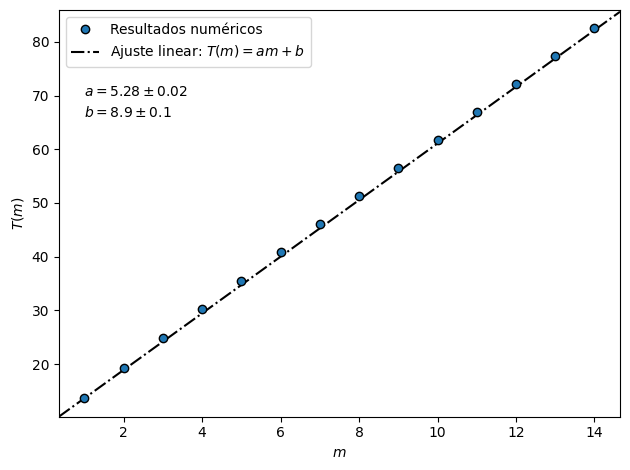

(5.275675675685001, 5.130199320647456, 2.8356862169477033)

In [61]:
m = np.arange(len(T3)) + 1
plt.plot(m, T3, 'o', c='tab:blue', markeredgecolor='k', label='Resultados numéricos')

(a, b), pcov = curve_fit(linear, m, T3)
da, db = np.sqrt(np.diag(pcov))
plt.axline((m[0], T3[0]), slope=a, ls='-.', c='k', zorder=0, label=r'Ajuste linear: $T(m) = am + b$')
plt.text(1, 70, r'$a = %s \pm %s$'%sig_digits(a, da))
plt.text(1, 66, r'$b = %s \pm %s$'%sig_digits(b, db))

plt.legend()
plt.xlabel(r'$m$')
plt.ylabel(r'$T(m)$')

plt.tight_layout()
plt.savefig('reports/anninos/ressonance_3.png')
plt.show()

w1 = 3**0.5/delta(LAMB)
c = 2*np.pi/w1
a, c, abs(c-a)/c*100